# Gradient Boosting Machines (GBMs) with XGBoost

This notebook is a part of [Machine Learning with Python: Zero to GBMs](https://zerotogbms.com) and [Zero to Data Science Bootcamp by Jovian](https://zerotodatascience.com)

![](https://i.imgur.com/6MYc56a.png)

The following topics are covered in this notebook:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

In [1]:
!pip install numpy pandas-profiling matplotlib seaborn --quiet

In [2]:
!pip install jovian opendatasets xgboost scikit-learn --upgrade --quiet

## Problem Statement

We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

In [3]:
# Importing required libraries
import os
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For better visualization
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Downloading the Data
We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [4]:
# This datasets are already downloaded
#od.download('https://www.kaggle.com/c/rossmann-store-sales')

In [5]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

Let's load the data into Pandas dataframes.

In [6]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [7]:
ross_df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
89669,470,2,2015-05-12,9369,1397,1,0,0,0
705837,828,1,2013-10-07,8790,845,1,1,0,0
264680,307,1,2014-12-01,4637,416,1,1,0,0
726767,573,3,2013-09-18,2798,243,1,0,0,0
681444,965,2,2013-10-29,5587,711,1,0,0,0


In [8]:
store_df.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
839,840,a,a,1070.0,9.0,2009.0,0,NaN,NaN,NaN
437,438,d,c,1110.0,NaN,NaN,1,40.0,2012.0,"Jan,Apr,Jul,Oct"
696,697,d,a,3780.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
1071,1072,a,c,5380.0,8.0,2015.0,1,5.0,2010.0,"Feb,May,Aug,Nov"
1091,1092,a,a,300.0,7.0,2000.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [9]:
test_df.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
30795,30796,1089,4,2015-08-13,1.0,0,0,0
14665,14666,150,1,2015-08-31,1.0,1,0,0
23210,23211,131,5,2015-08-21,1.0,1,0,0
3705,3706,365,7,2015-09-13,0.0,0,0,0
35079,35080,1096,6,2015-08-08,1.0,0,0,0


In [10]:
submission_df.sample(5)

,Id,Sales
20432,20433,0
40099,40100,0
7303,7304,0
28526,28527,0
20936,20937,0


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [11]:
merged_df = ross_df.merge(store_df, how='left', on="Store")
merged_test_df = test_df.merge(store_df, how='left', on='Store')
merged_df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
824917,603,6,2013-06-22,5405,783,1,0,0,0,a,a,340.0,4.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
161530,971,1,2015-03-09,5570,801,1,0,0,0,c,a,1140.0,5.0,2011.0,1,14.0,2012.0,"Mar,Jun,Sept,Dec"
547132,453,3,2014-02-26,5333,704,1,0,0,0,a,c,75860.0,NaN,NaN,0,NaN,NaN,NaN
655869,1035,4,2013-11-21,7302,809,1,1,0,0,a,a,27150.0,NaN,NaN,0,NaN,NaN,NaN
572330,6,1,2014-02-03,7748,851,1,1,0,0,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [13]:
def split_date(df):
    df['Date']= pd.to_datetime(df["Date"])
    df["Year"]= df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Day"] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [14]:
split_date(merged_df)
split_date(merged_test_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [15]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [16]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [17]:
def comp_months(df):
    df['CompetitionOpen']= 12*(df.Year-df.CompetitionOpenSinceYear) + (df.Year-df.CompetitionOpenSinceMonth)
    df['CompetitionOpen']= df["CompetitionOpen"].map(lambda x:0 if x<0 else x).fillna(0)

In [18]:
comp_months(merged_df)
comp_months(merged_test_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,2090.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,2100.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,2111.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,2078.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,...,2006.0,0,NaN,NaN,NaN,2013,1,1,1,2088.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,1999.0,0,NaN,NaN,NaN,2013,1,1,1,2171.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [19]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [20]:
promo_cols(merged_df)
promo_cols(merged_test_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,2090.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,2100.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,2111.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,2078.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,2011.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,2088.0,0.000000,0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,2171.0,0.000000,0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,1.213115,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,0.0,0.000000,0


### Input and Target Columns

Let's select the columns that we'll use for training.

In [21]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [22]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [23]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [24]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [25]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [26]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [27]:
max_distance = 2*inputs.CompetitionDistance.max()
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [28]:
# Import and fit scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inputs[numeric_cols])

# Scalling
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [29]:
# Import and fit encoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse= False, handle_unknown="ignore").fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

# Encoding
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [30]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

> **EXERCISE**: Look through the notebooks created by participants in the Kaggle competition and apply some other ideas for feature engineering. https://www.kaggle.com/c/rossmann-store-sales/code?competitionId=4594&sortBy=voteCount

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library. And then evaluate it with `mean_square_error` function.

In [31]:
# Importing Libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Training the model
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)
model.fit(X, targets)

# Predicting
preds = model.predict(X)

# Calculeting RMSE error
mean_squared_error(preds, targets, squared=False)

2383.9192331276704

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [32]:
trees = model.get_booster().get_dump()
len(trees)
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00220830599] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.00800922886] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.00672379695] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.00135135138] yes=27,no=28,missing=27
				27:le

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

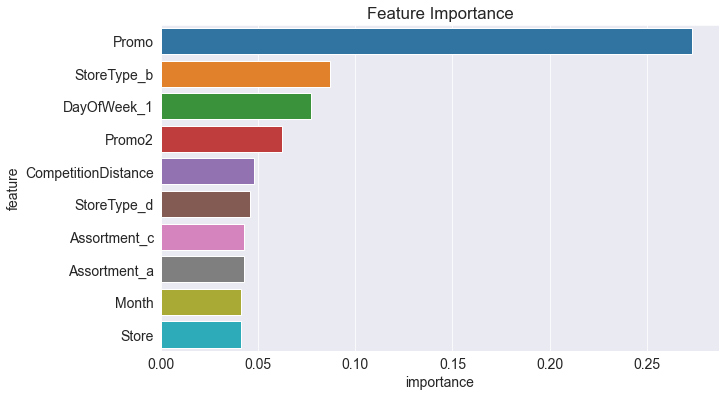

In [33]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [35]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state =42, **params)
    model.fit(X_train, train_targets)
    train_rmse = mean_squared_error(model.predict(X_train), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val), val_targets, squared=False)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
    return [train_rmse, val_rmse]

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [38]:
# Training model
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7, seed =1301)


In [39]:
model.fit(X, targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1301,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [40]:
# Predicting Values
test_preds = model.predict(X_test)

In [58]:
test_df['Open'] =test_df.Open.fillna(1.) 
test_df.Open

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
41083    1.0
41084    1.0
41085    1.0
41086    1.0
41087    1.0
Name: Open, Length: 41088, dtype: float64

In [59]:
# Setting the values to submission_df
submission_df['Sales']  = test_preds
submission_df['Sales'] = submission_df['Sales'] * test_df.Open

submission_df

,Id,Sales
0,1,3847.245605
1,2,7625.776855
2,3,8888.398438
3,4,7149.221680
4,5,6863.892090
...,...,...
41083,41084,2877.376953
41084,41085,7651.715332
41085,41086,6801.257812
41086,41087,22720.900391


In [61]:
# Saving submission df as csv file
submission_df.to_csv('submission.csv', index=None)

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1

## Revision Questions
1.	What is a Gradient Boosting Machine (GBM) model?
2.	What does term ‘gradient’ refer to?
3.	What does term ‘boosting’ refer to?
4.	What are weights and bias?
5.	How to choose differentiate/choose numerical and categorical columns?
6.	Why do you scale numerical columns?
7.	Why do you encode categorical columns?
8.	What is rankdir in <code>plot_tree()</code>?
9.	What is the working of K-fold cross validation?
10.	How does gamma hyperparameter work?
11.	What is generalization?
12.	What is ensembling?
13.	What are the different ways to impute missing data?
14.	What are the advantages of XGBoost?
15.	What are the disadvantages of XGBoost?
16.	What are the data pre-processing steps for XGBoost?
17.	What is <code>rcParams</code>?
18.	What does <code>get_dump()</code> do?
19.	What is the difference between XGBoost and LightGBM?
20.	Is XGBoost faster than Random Forest? If so, why?